# Survival Analysis on Patients Diagnosed with Colon Cancer


In [12]:
#General imports
import os
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import dill
import time

#Project specific imports
from lifelines import KaplanMeierFitter
from pysurvival.utils.display import correlation_matrix
from sklearn.model_selection import train_test_split
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
from pysurvival.models.svm import LinearSVMModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import create_risk_groups
from sklearn.model_selection import ParameterGrid
from contextlib import contextmanager


In [13]:
#util functions
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [2]:
#load in data
colon_df = pd.read_excel('colon.xlsx')
display(colon_df.head(10))

,id,sex,age,obstruct,perfor,adhere,nodes,extent,surg,node4,time,status
0,1,1,43,0,0,0,5.0,3,0,1,968,1
1,2,1,63,0,0,0,1.0,3,0,0,3087,0
2,3,0,71,0,0,1,7.0,2,0,1,542,1
3,4,0,66,1,0,0,6.0,3,1,1,245,1
4,5,1,69,0,0,0,22.0,3,1,1,523,1
5,6,0,57,0,0,0,9.0,3,0,1,904,1
6,7,1,77,0,0,0,5.0,3,1,1,229,1
7,8,1,54,0,0,0,1.0,3,0,0,3192,0
8,9,1,46,0,0,1,2.0,3,0,0,3173,0
9,10,0,68,0,0,0,1.0,3,1,0,3308,0


In [4]:
colon_df.describe()

,id,sex,age,obstruct,perfor,adhere,nodes,extent,surg,node4,time,status
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,911.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,465.000000,0.520990,59.754575,0.193757,0.029064,0.145318,3.659715,2.886975,0.265877,0.274489,1405.135630,0.503767
std,268.323499,0.499828,11.948887,0.395453,0.168075,0.352611,3.572562,0.488149,0.442037,0.446497,998.900763,0.500255
min,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.000000,0.000000
25%,233.000000,0.000000,53.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,370.000000,0.000000
50%,465.000000,1.000000,61.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1548.000000,1.000000
75%,697.000000,1.000000,69.000000,0.000000,0.000000,0.000000,5.000000,3.000000,1.000000,1.000000,2289.000000,1.000000
max,929.000000,1.000000,85.000000,1.000000,1.000000,1.000000,33.000000,4.000000,1.000000,1.000000,3329.000000,1.000000


#### Premises for this Time to Event Analysis
Starting point = time of diagnosis

Event of interest = death

Right censoring (for members who did not experience event of interest) indicated by status=0

Left censoring is not needed because we are going to do a study period that will include everybody's starting point from this dataset.

In [5]:
#find out members with max time in study
colon_df.sort_values('time',ascending=False).head(5)


,id,sex,age,obstruct,perfor,adhere,nodes,extent,surg,node4,time,status
19,20,0,50,0,0,1,1.0,3,0,0,3329,0
86,87,0,62,0,0,0,2.0,2,0,0,3325,0
11,12,1,52,0,0,0,2.0,3,1,0,3309,0
9,10,0,68,0,0,0,1.0,3,1,0,3308,0
30,31,0,64,0,0,0,1.0,1,0,0,3238,0


Based on above, we are conducting a 3329 days study period.

## Simple Kaplan Meier Analysis

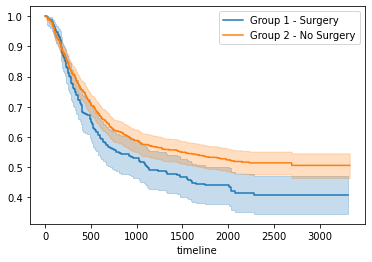

In [6]:
#KM curve comparing survival rate between surgery or not
group1=colon_df[colon_df['surg']==1]
group2=colon_df[colon_df['surg']==0]
T=group1['time']
E=group1['status']
T1=group2['time']
E1=group2['status']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Surgery").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - No Surgery").plot(ax=ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

## Survival Prediction with PySurvival
Using Conditional Survival Forest model following this guide: https://square.github.io/pysurvival/tutorials/employee_retention.html

In [3]:
# Creating the time and event columns
time_column = 'time'
event_column = 'status'

#Creating age groups
bins = [18, 30, 40, 50, 60, 70, 140]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
colon_df['agerange'] = pd.cut(colon_df.age, bins, labels = labels, include_lowest = True)

#Creating nodes groups
bins = [0, 4, 8, 15, 29, 99]
labels = ['0-3' ,'4-7', '8-14', '15-28', '29+']
colon_df['nodesrange'] = pd.cut(colon_df.nodes, bins, labels = labels, include_lowest = True)

# Creating one-hot vectors for categorical features
category_columns = ['agerange', 'nodesrange']
dataset = pd.get_dummies(colon_df, columns=category_columns, drop_first=True)
dataset.head()


,id,sex,age,obstruct,perfor,adhere,nodes,extent,surg,node4,...,status,agerange_30-39,agerange_40-49,agerange_50-59,agerange_60-69,agerange_70+,nodesrange_4-7,nodesrange_8-14,nodesrange_15-28,nodesrange_29+
0,1,1,43,0,0,0,5.0,3,0,1,...,1,0,1,0,0,0,1,0,0,0
1,2,1,63,0,0,0,1.0,3,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,0,71,0,0,1,7.0,2,0,1,...,1,0,0,0,0,1,1,0,0,0
3,4,0,66,1,0,0,6.0,3,1,1,...,1,0,0,0,1,0,1,0,0,0
4,5,1,69,0,0,0,22.0,3,1,1,...,1,0,0,0,1,0,0,0,1,0


In [4]:
#columns to exclude
patient_id = 'id'
age = 'age'
nodes = 'nodes'

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column, patient_id, age, nodes] ).tolist()
display(features)

['adhere',
 'agerange_30-39',
 'agerange_40-49',
 'agerange_50-59',
 'agerange_60-69',
 'agerange_70+',
 'extent',
 'node4',
 'nodesrange_15-28',
 'nodesrange_29+',
 'nodesrange_4-7',
 'nodesrange_8-14',
 'obstruct',
 'perfor',
 'sex',
 'surg']

In [5]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]
N

The dataset contains 0 null values
The dataset contains 0 duplicates


929

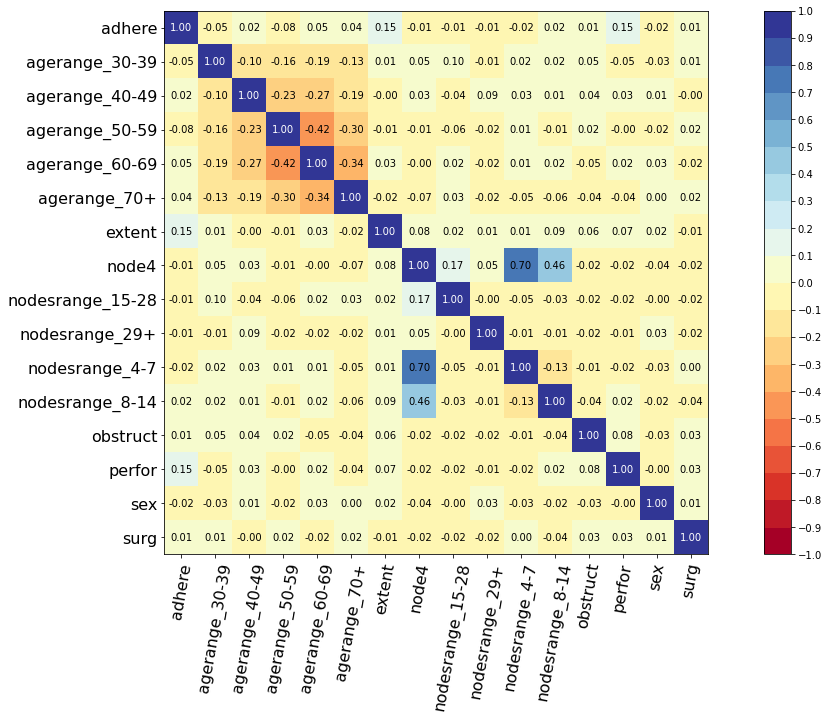

In [6]:
#Check for closely correlated features
correlation_matrix(dataset[features], figure_size=(20,10), text_fontsize=10)

#### There is mild correlation between nodes (number of abnormal tissues) and node4 (presence of a malignant tumor)

### Splitting Data and Training Model

In [8]:
# random indexes choice
indexes_choices = np.random.choice(N, int(N*1.0), replace=False).tolist()

# Building training and testing sets #
index_train, index_test = train_test_split( indexes_choices, test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

### Grid Search for Hyperparameters Tuning (Linear Survival SVM)

In [14]:
param_grid = {'init_method': ['he_uniform', 'glorot_uniform', 'ones', 'zeros'], 
              'with_bias': [True, False],
              'lr': [0.05, 0.50, 0.75],
              'tol': [1e-3, 1e-1, 1e-7],
              'l2_reg': [1e-3, 1e-1, 1e-7]
             }
grid = ParameterGrid(param_grid)
print('Number of possible hyperparameters combinations: {}'.format(len(grid)))

best_score_svm = 0
best_model_svm = None
best_params_svm = None
t0 = time.time()

for params in grid:
    #training
    with suppress_stdout():
        svm_model = LinearSVMModel()
        svm_model.fit(X_train, T_train, E_train, init_method=params['init_method'],
                      with_bias = params['with_bias'], lr = params['lr'],
                      tol = params['tol'],  l2_reg = params['l2_reg'])
    #scoring
    score = concordance_index(svm_model, X_test, T_test, E_test)
    if score > best_score_svm:
        best_score_svm = score
        best_model_svm = svm_model
        best_params_svm = params
    #timing
    t1 = time.time()
    time_elapsed = t1-t0
    print('Time elapsed: {:.2f} seconds'.format(time_elapsed), end="\r")

print('\nC-index of best model: {:.2f}'.format(best_score_svm))
print('Params of best model: {}'.format(best_params_svm))

Number of possible hyperparameters combinations: 216
Time elapsed: 105.83 seconds
C-index of best model: 0.63
Params of best model: {'init_method': 'glorot_uniform', 'l2_reg': 1e-07, 'lr': 0.5, 'tol': 0.1, 'with_bias': True}


### Grid Search for Hyperparameters Tuning (Conditional Survival Forest)

In [12]:
param_grid = {'num_trees': [50, 100, 200], 
              'max_features': ['sqrt', 'log2', 'all'],
              'alpha': [0.05, 0.15, 0.35],
              'minprop': [0.05, 0.10, 0.35],
              'max_depth': [3, 10, 28],
              'min_node_size': [17, 35, 128]
             }
grid = ParameterGrid(param_grid)
print('Number of possible hyperparameters combinations: {}'.format(len(grid)))

best_score_csf = 0
best_model_csf = None
best_params_csf = None
t0 = time.time()

for params in grid:
    #training
    csf = ConditionalSurvivalForestModel(params['num_trees'])
    csf.fit(X_train, T_train, E_train, max_features=params['max_features'],
            alpha=params['alpha'], minprop=params['minprop'], max_depth=params['max_depth'],
            min_node_size=params['min_node_size'])
    #scoring
    score = concordance_index(csf, X_test, T_test, E_test)
    if score > best_score_csf:
        best_score_csf = score
        best_model_csf = csf
        best_params_csf = params
    #timing
    t1 = time.time()
    time_elapsed = t1-t0
    print('Time elapsed: {:.2f} seconds'.format(time_elapsed), end="\r")

print('\nC-index of best model: {:.2f}'.format(best_score_csf))
print('Params of best model: {}'.format(best_params_csf))
# Computing variables importance
best_model_csf.variable_importance_table.head(10)

Number of possible hyperparameters combinations: 729
Time elapsed: 1083.51 seconds
C-index of best model: 0.65
Params of best model: {'alpha': 0.05, 'max_depth': 28, 'max_features': 'log2', 'min_node_size': 17, 'minprop': 0.05, 'num_trees': 50}


,feature,importance,pct_importance
0,node4,2.988832,0.239688
1,nodesrange_8-14,1.824391,0.146306
2,nodesrange_4-7,1.740211,0.139555
3,surg,1.436823,0.115225
4,extent,1.358059,0.108909


In [17]:
#pick a best model
best_model = best_model_csf

### Metrics: C-index
Ranges from 0.5 to 1.0

1.0 being really good at discrimating between high risk or low risk patients

In [13]:
c_index = concordance_index(best_model, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.65


### Metrics: Brier Score
Measures the average discrepancies between the status and the estimated probabilities at a given time.

The lower the score (usually below 0.25), the better the predictive performance

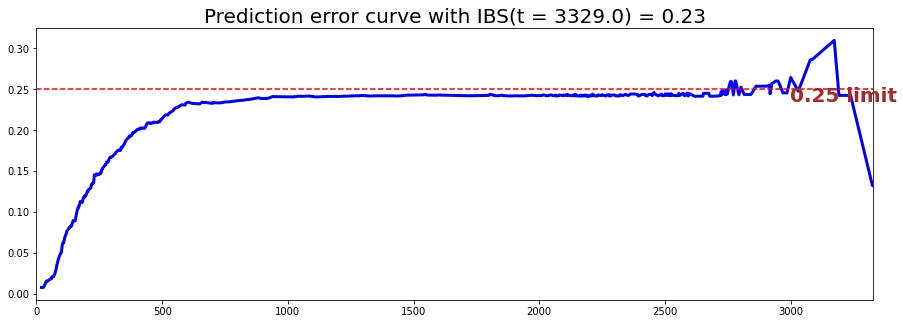

IBS: 0.23


In [14]:
#calculate brier score for 3329 days study period
ibs = integrated_brier_score(best_model, X_test, T_test, E_test, t_max=3329,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

### Actual vs Predicted
Comparing the predicted number of patients who dies, for each time t.

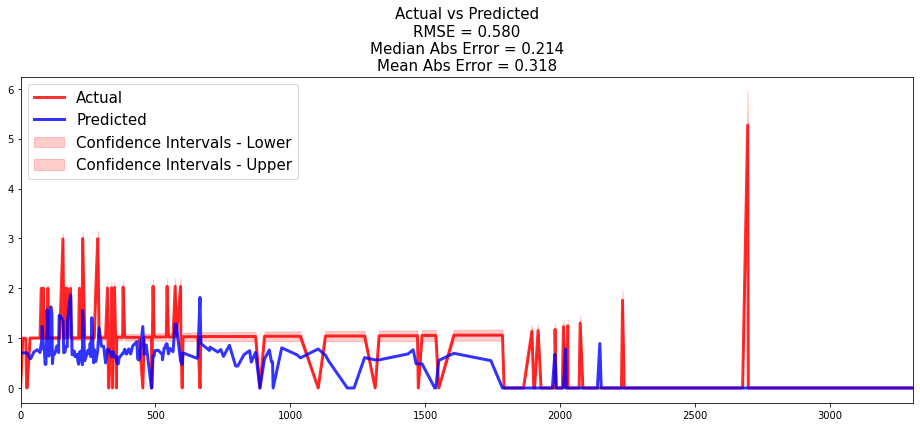

In [15]:
results = compare_to_actual(best_model, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

### Creating Risk Groups
The CSF model will return risk scores for each individual.

By plotting the distribution of predicted risk scores, we can intuitively assign risk groups.

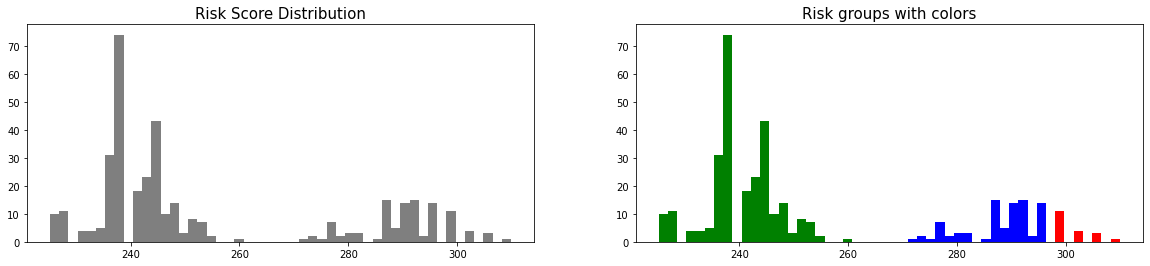

In [22]:
risk_groups = create_risk_groups(model=best_model, X=X_test,
    use_log = False, num_bins=50, figure_size=(20, 4),
    low= {'lower_bound':0, 'upper_bound':263, 'color':'green'},
    medium= {'lower_bound':263, 'upper_bound':295, 'color':'blue'},
    high= {'lower_bound':295, 'upper_bound':500, 'color':'red'}
    )

### Survival Curve for different Risk Groups

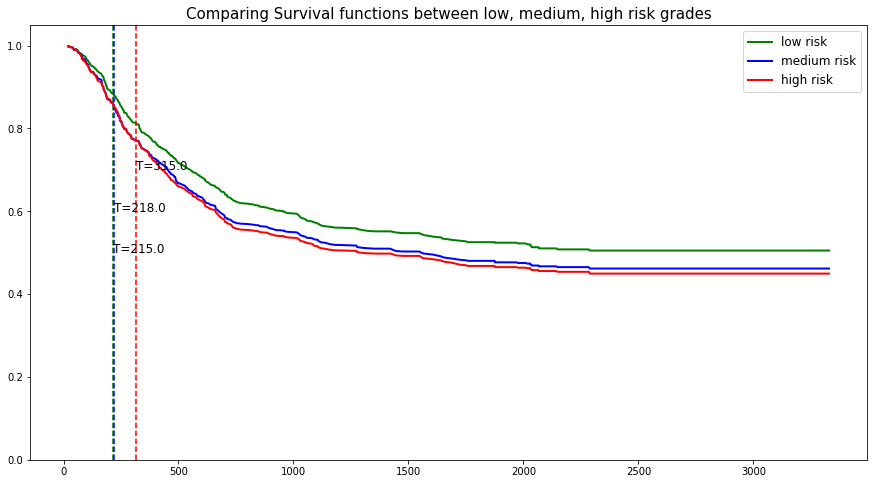

In [23]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 8))

# Selecting a random individual that experienced failure from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = best_model.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(best_model.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

### Return List of High Risk Patients

In [24]:
high_risk_indexes = risk_groups["high"][1]
high_risk_patients = dataset.loc[high_risk_indexes]

risk_scores = []
for index, row in high_risk_patients[features].iterrows():
    risk_score = best_model.predict_risk(row)
    risk_scores.append(risk_score[0])
    
high_risk_patients['risk_score'] = risk_scores
display(high_risk_patients.sort_values('risk_score',ascending=False))

,id,sex,age,obstruct,perfor,adhere,nodes,extent,surg,node4,...,agerange_30-39,agerange_40-49,agerange_50-59,agerange_60-69,agerange_70+,nodesrange_4-7,nodesrange_8-14,nodesrange_15-28,nodesrange_29+,risk_score
222,223,0,51,0,0,1,5.0,3,1,1,...,0,0,1,0,0,1,0,0,0,299.327681
273,274,0,67,1,0,0,12.0,3,0,1,...,0,0,0,1,0,0,1,0,0,298.637004
358,359,0,60,0,1,0,10.0,3,1,1,...,0,0,1,0,0,0,1,0,0,298.130418
67,68,1,60,0,0,0,10.0,3,0,1,...,0,0,1,0,0,0,1,0,0,296.163524
66,67,1,49,0,0,0,6.0,3,0,1,...,0,1,0,0,0,1,0,0,0,292.628765
84,85,1,45,0,0,0,8.0,3,0,1,...,0,1,0,0,0,1,0,0,0,292.628765
156,157,0,52,0,1,0,6.0,3,0,1,...,0,0,1,0,0,1,0,0,0,291.871158
74,75,0,71,0,0,0,7.0,3,0,1,...,0,0,0,0,1,1,0,0,0,289.644546
28,29,0,56,1,0,0,6.0,3,0,1,...,0,0,1,0,0,1,0,0,0,287.171066
198,199,0,32,0,0,0,NaN,3,1,1,...,1,0,0,0,0,0,0,0,0,281.930083
